In [1]:
%load_ext autoreload
%autoreload 2
from anndata import AnnData
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
#%matplotlib widget
import cv2
import torch
from skimage import io, morphology
import skimage.feature as features
from scipy import ndimage
import time
from tqdm.notebook import tqdm
import scipy
import seaborn as sns
import skimage
from skimage.measure import regionprops, regionprops_table, approximate_polygon
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
import geopandas
import scanpy as sc
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon
import matplotlib
from matplotlib.colors import Normalize
import spatialdata as sd
import napari
import numpy as np
import pandas as pd
from spatialdata import read_zarr
import napari_sparrow as sp
import os
import seaborn as sns 
os.environ["USE_PYGEOS"] = "0"

/home/wout/mambaforge/envs/napari-sparrow/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_9421/3484544265.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/l

## Read in the data 

In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/PS'
sdata = read_zarr(os.path.join(  OUTPUT_DIR, 'sdata.zarr'  ) )
name_anndata = "ps_slice"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold')

In [3]:
sdata

SpatialData object with:
├── Images
│     ├── 'KC': SpatialImage[cyx] (1, 12864, 15008)
│     ├── 'clahe': SpatialImage[cyx] (1, 12864, 15008)
│     ├── 'complete_image': SpatialImage[cyx] (5, 12864, 15008)
│     ├── 'min_max_filtered': SpatialImage[cyx] (1, 12864, 15008)
│     ├── 'raw_image': SpatialImage[cyx] (1, 12864, 15008)
│     ├── 'tiling_correction': SpatialImage[cyx] (1, 12864, 15008)
│     └── 'transcript_density': SpatialImage[cyx] (1, 12864, 15008)
├── Labels
│     └── 'segmentation_mask': SpatialImage[yx] (12864, 15008)
├── Points
│     └── 'transcripts': DataFrame with shape: (6046453, 3) (2D points)
├── Shapes
│     ├── 'filtered_low_counts_segmentation_mask_boundaries': GeoDataFrame shape: (1619, 1) (2D shapes)
│     ├── 'filtered_low_counts_segmentation_mask_boundaries_napari': GeoDataFrame shape: (1619, 1) (2D shapes)
│     ├── 'filtered_segmentation_segmentation_mask_boundaries': GeoDataFrame shape: (437, 1) (2D shapes)
│     ├── 'filtered_segmentation_segmentation

In [4]:
del sdata.table
sdata.table = anndata
sdata.table

AnnData object with n_obs × n_vars = 11794 × 96
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central', 'central_vein_EC45', 'stellateAll', 'stellate PeriPortal', 'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal', 'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45', 'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal', 'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac', 'Portal LAM macrophages', 'Monocytes', 'LECs', 'cleanliness_score_genes_original_BasicMartin_12', 'annotation_score_genes_original_BasicMartin_12', 'Hep', 'KC_intensity', 'annotationSave', 'score_celltype_own_score_genes_BasicMartin_12', 'second_sco

## Open Napari and plot the images

In [5]:
viewer = napari.Viewer() # open napari
viewer.add_image(sdata['raw_image'])  # load in image

<Image layer 'Image' at 0x7ddc7f9b4850>

## Add cells to the mix

In [6]:
def prepare_napari_plot(sdata,cutoff_shapes=0.5,shapes_layer='segmentation_mask_boundaries',output_layer='to_plot_napari'):
    '''create polygons instead of multipolygons and simplify the shapes so the plotting is faster.'''
    temp=sdata[shapes_layer].explode()
    temp['Area']=temp.area
    temp=temp.sort_values(by='Area',ascending=False)
    temp.index=temp.index.droplevel(1)
    temp = temp[~temp.index.duplicated(keep='first')]
    if shapes_layer=='segmentation_mask_boundaries':
        temp=temp.reindex(sdata.table.obs.index)
    #adata=adata[temp.percent_area>cutoff_shapes,:]
    
    
    sdata.add_shapes(
                name=output_layer,
                shapes=sd.models.ShapesModel.parse(temp
                ),
                overwrite=True,
            )
    #adata.obsm['napari_plot']=temp2[['geometry','percent_area']]
    return sdata 

In [7]:
def add_napari_layer(sdata,column=None,name=None,celltype=None,colormap='magma'):
    """
    Function to plot the cells into napari, colored by the correct olumn
    If you want a subset, just take a subset of the anndata before adding this. Don't use the function to change color, only to add an extra layer."""
    if celltype: 
        adata=sdata.table[sdata.table.obs['annotation_own_score_genes']==celltype,:]
        if not name:
            name=celltype
    else:
        adata=sdata.table
    coords_to_plot=[]
    to_color=None
    #adata.obsm['napari_plot']=geopandas.GeoDataFrame(adata.obsm['napari_plot'],geometry=adata.obsm['napari_plot']['geometry'])
    if column:
        if column + "_colors" in adata.uns:
                color_dict=dict(zip(adata.obs[column].cat.categories.values,adata.uns[column + "_colors"]))
                to_color=adata.obs[column].map(color_dict)
                print('colors from adata used')
    for i in sdata['to_plot_napari'].loc[adata.obs.index.values].geometry.exterior.simplify(tolerance=2):
        coords_to_plot.append(np.array(i.coords)[:,[1,0]]) 
    Columns=dict(zip(adata.var.index.values,adata.X.T))
    Columns.update(adata.obs.to_dict('list'))
    if not name:
        name=column
    if name in viewer.layers:
        viewer.layers[name].features=Columns
        if to_color:
            print('layer reused')
            viewer.layers[name].face_color=to_color.values
        if column in viewer.layers[name].features:
            print('layer reused')
            viewer.layers[name].face_color=column
            viewer.layers[name].face_colormap =colormap
    elif to_color is not None:
        viewer.add_shapes(coords_to_plot,name=name,shape_type='polygon',face_color=to_color.values.astype(str),opacity=0.7,edge_width=3,edge_color='white',features=Columns)
    elif column in Columns.keys():
        viewer.add_shapes(coords_to_plot,name=name,shape_type='polygon',face_color=column,opacity=0.7,edge_width=3,edge_color='white',features=Columns,face_colormap=colormap)
    elif column==None:
        viewer.add_shapes(coords_to_plot,name=name,shape_type='polygon',face_color=colormap,opacity=0.7,edge_width=3,edge_color='white',features=Columns)

In [8]:
annotation = 'annotation_own_score_genes_BasicMartin_12'
add_napari_layer(sdata,annotation)

colors from adata used


## Add points into the mix

In [9]:
df=sdata.points['transcripts'].compute()

In [10]:
Vwf=['Vwf']
viewer.add_points(df[df['gene'].isin(Vwf)][['y','x']].values,size=50,face_color='red',name='Vwf') # I have put the size on 15, if you want to zoom less to see the spots, you can

<Points layer 'Vwf' at 0x7ddbf44a1c00>

## Load polygons back into python

In [11]:
import rasterio
def mask_to_polygons_layer(mask: np.ndarray) -> geopandas.GeoDataFrame:
    """Returns the polygons as GeoDataFrame

    This function converts the mask to polygons.
    https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/
    """

    all_polygons = []
    all_values = []

    # Extract the polygons from the mask
    for shape, value in features.shapes(
        mask.astype(np.int32),
        mask=(mask > 0),
        transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0),
    ):
        all_polygons.append(shapely.geometry.shape(shape))
        all_values.append(int(value))

    return geopandas.GeoDataFrame(dict(geometry=all_polygons), index=all_values)

In [12]:
shape=sdata['raw_image'].shape

In [14]:
Edges = viewer.layers['edges'].to_labels(labels_shape=shape)

In [15]:
Veins = viewer.layers['veins'].to_labels(labels_shape=shape)

In [16]:
edges_shapes=mask_to_polygons_layer(Edges)
edges_shapes= edges_shapes.reset_index()

In [17]:
veins_shapes=mask_to_polygons_layer(Veins)
veins_shapes= veins_shapes.reset_index()

In [18]:
df=pd.DataFrame(index=sdata.table.obs.index)
for i in edges_shapes.index.values:
    df[i]=sdata['segmentation_mask_boundaries'].distance(edges_shapes.loc[i].geometry)
sdata.table.obs['distance_to_edge']=df.min(axis=1)

/tmp/ipykernel_9421/1848292458.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=sdata['segmentation_mask_boundaries'].distance(edges_shapes.loc[i].geometry)
/tmp/ipykernel_9421/1848292458.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=sdata['segmentation_mask_boundaries'].distance(edges_shapes.loc[i].geometry)
/tmp/ipykernel_9421/1848292458.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [19]:
df=pd.DataFrame(index=sdata.table.obs.index)
for i in veins_shapes.index.values:
    df[i]=sdata['segmentation_mask_boundaries'].distance(veins_shapes.loc[i].geometry)
sdata.table.obs['distance_to_vein']=df.min(axis=1)

/tmp/ipykernel_9421/2534239685.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=sdata['segmentation_mask_boundaries'].distance(veins_shapes.loc[i].geometry)
/tmp/ipykernel_9421/2534239685.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i]=sdata['segmentation_mask_boundaries'].distance(veins_shapes.loc[i].geometry)
/tmp/ipykernel_9421/2534239685.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [20]:
def calculate_intensity(sdata):
    props = ['label','area', 'intensity_mean','eccentricity','extent','solidity']
    # area = shapeSize
    table=pd.DataFrame.from_dict(regionprops_table(sdata['segmentation_mask'].to_numpy(),intensity_image=sdata['clahe'].sel(c=0).to_numpy(),properties=props))
    table=table.set_index('label')
    table['filtered']=~table.index.isin(sdata.table.obs.index.values.astype(int))
    table = table[table['filtered']==False]
    table = table.drop(columns=['filtered'])
    return table

In [21]:
table_props = calculate_intensity(sdata)
sdata.table.obs['area'] = table_props['area'].to_list()
sdata.table.obs['eccentricity'] = table_props['eccentricity'].to_list()
sdata.table.obs['extent'] = table_props['extent'].to_list()
sdata.table.obs['solidity'] = table_props['solidity'].to_list()
sdata.table.obs['intensity_mean'] = table_props['intensity_mean'].to_list()

In [22]:
sdata.table.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,...,annotation_own_score_genes_start_iterative_HLMartin_7,annotation_tangram_11,annotation_tangram_7,distance_to_edge,distance_to_vein,area,eccentricity,extent,solidity,intensity_mean
cells,,,,,,,,,,,,,,,,,,,,,
335,1,1,7,2.079442,25,3.258097,60.000000,92.000000,25,3368.0,...,Strom,Meso,Strom,5.000000,349.400916,3368.0,0.814145,0.690872,0.922993,3321.482185
359,1,1,5,1.791759,247,5.513429,90.688259,100.000000,247,3596.0,...,Unknown,Hepa,Hepa,107.000000,1254.971713,3596.0,0.450551,0.704269,0.948813,5141.758621
431,1,1,8,2.197225,56,4.043051,71.428571,92.857143,56,2868.0,...,Hepa,Hepa,Hepa,370.000000,538.282454,2868.0,0.411929,0.735385,0.977172,5656.474895
439,1,1,11,2.484907,216,5.379897,69.907407,93.055556,216,3595.0,...,Hepa,Hepa,Hepa,91.000000,2579.544533,3595.0,0.393648,0.639566,0.914526,5085.805563
471,1,1,5,1.791759,124,4.828314,91.935484,100.000000,124,3080.0,...,Unknown,Hepa,Hepa,161.607549,1320.898179,3080.0,0.874463,0.720131,0.962801,4359.947403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35146,1,1,16,2.833213,47,3.871201,38.297872,68.085106,47,2793.0,...,Endo,Hepa,Hepa,4016.119645,10.049876,2793.0,0.846799,0.654098,0.969792,7264.488006
35210,1,1,6,1.945910,43,3.784190,76.744186,97.674419,43,1357.0,...,Endo,Portal vein,Endo,4019.000000,0.000000,1357.0,0.340042,0.807738,0.976259,8306.563007
35274,1,1,4,1.609438,13,2.639057,76.923077,100.000000,13,1348.0,...,Strom,Hepa,Hepa,4026.152133,19.209373,1348.0,0.770103,0.655005,0.932872,3836.213650


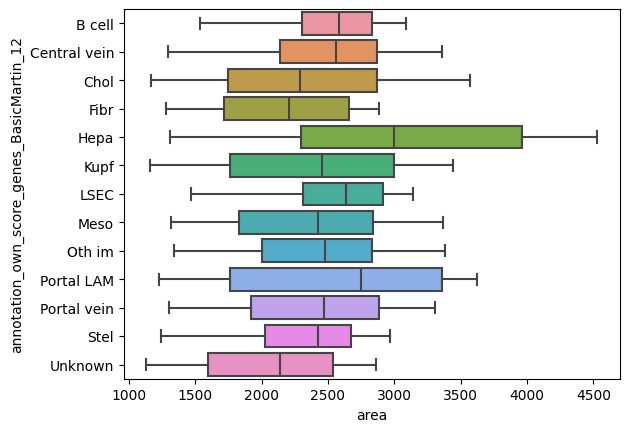

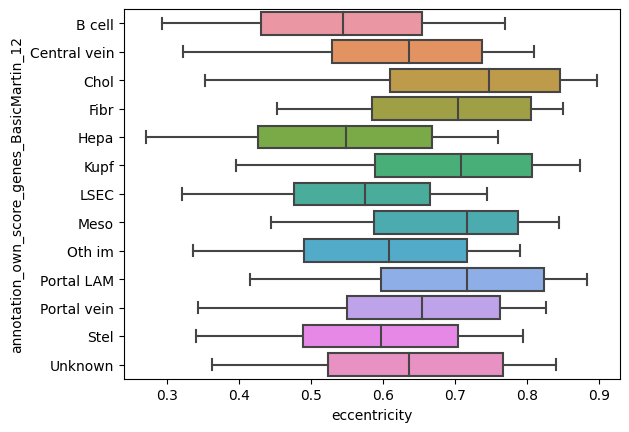

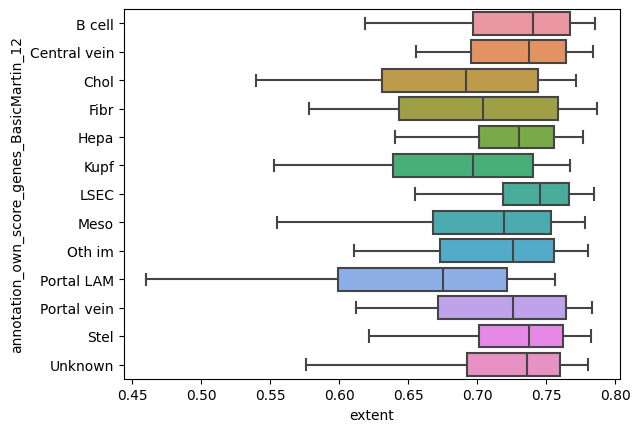

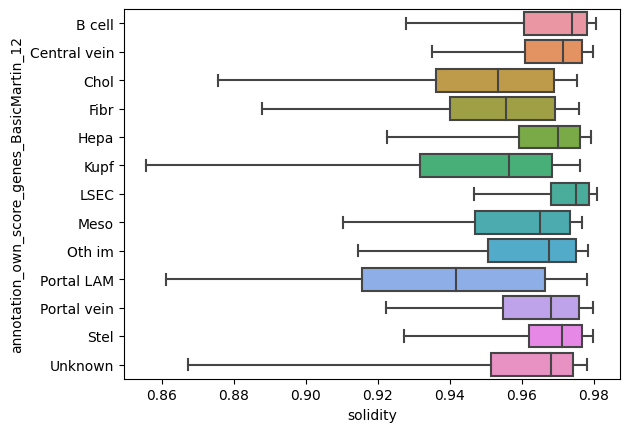

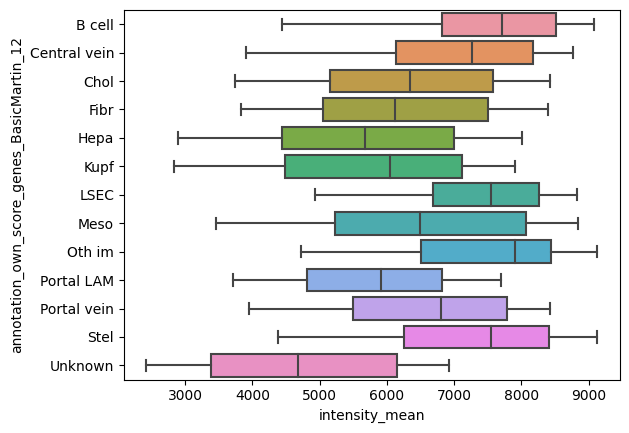

In [23]:
sns.boxplot(y=annotation,x='area',data=sdata.table.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='eccentricity',data=sdata.table.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='extent',data=sdata.table.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='solidity',data=sdata.table.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='intensity_mean',data=sdata.table.obs,whis=(5,90),showfliers=False)
plt.show()


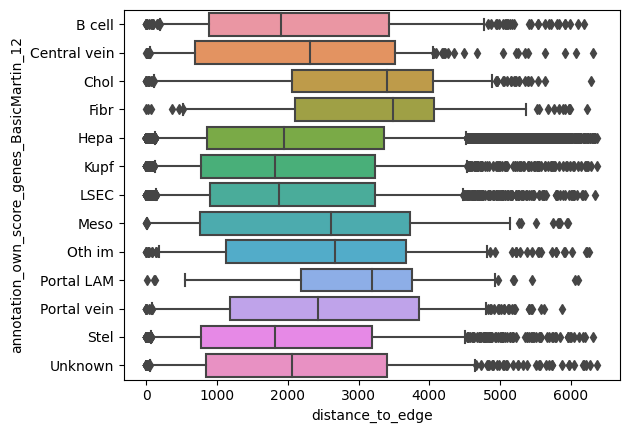

In [24]:
sns.boxplot(y=annotation,x='distance_to_edge',data=sdata.table.obs,whis=(5,90),showfliers=True)
plt.show()

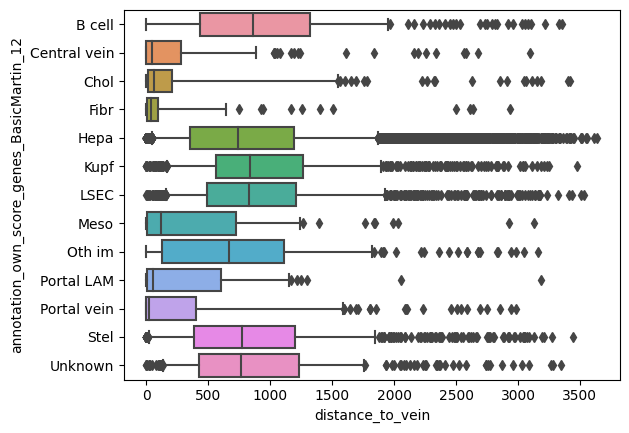

In [25]:
sns.boxplot(y=annotation,x='distance_to_vein',data=sdata.table.obs,whis=(5,90),showfliers=True)
plt.show()

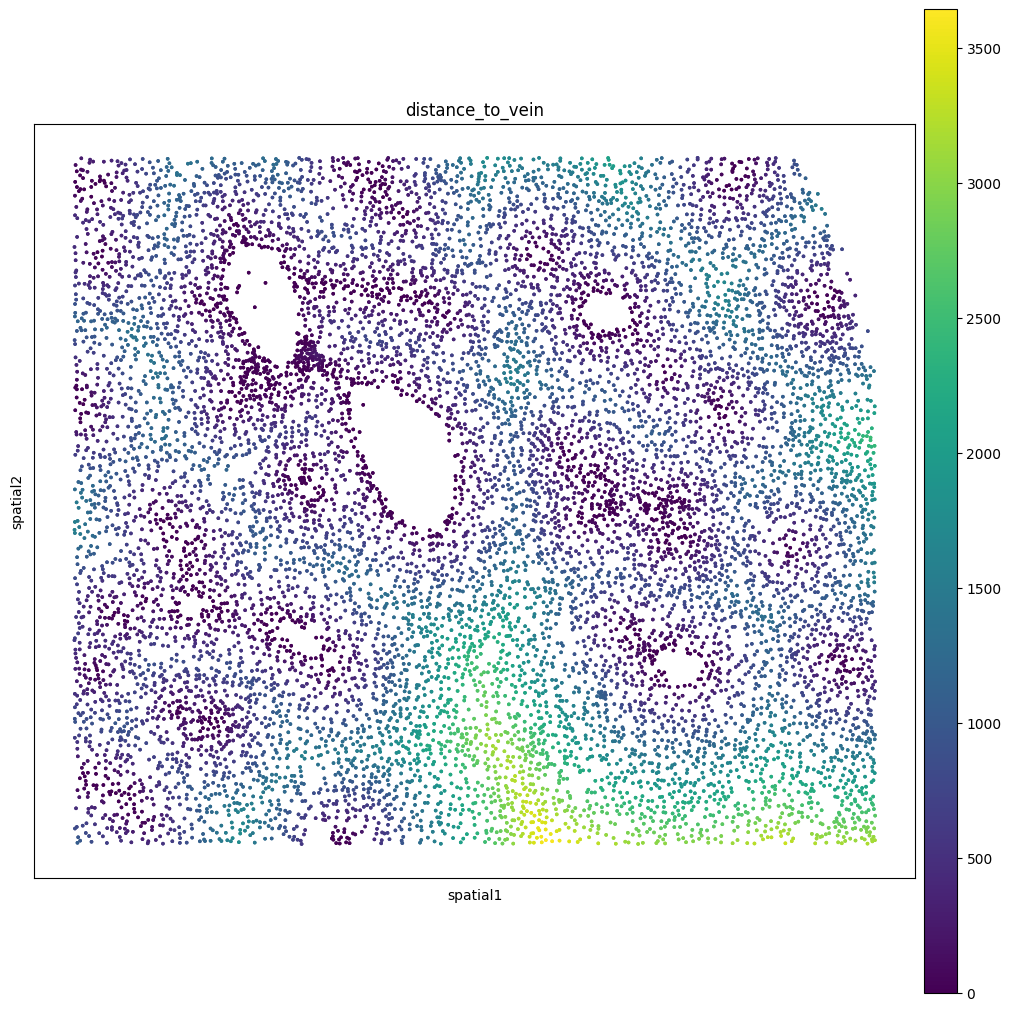

In [26]:
sq.pl.spatial_scatter(anndata,color='distance_to_vein',shape=None, figsize=(10, 10)) 

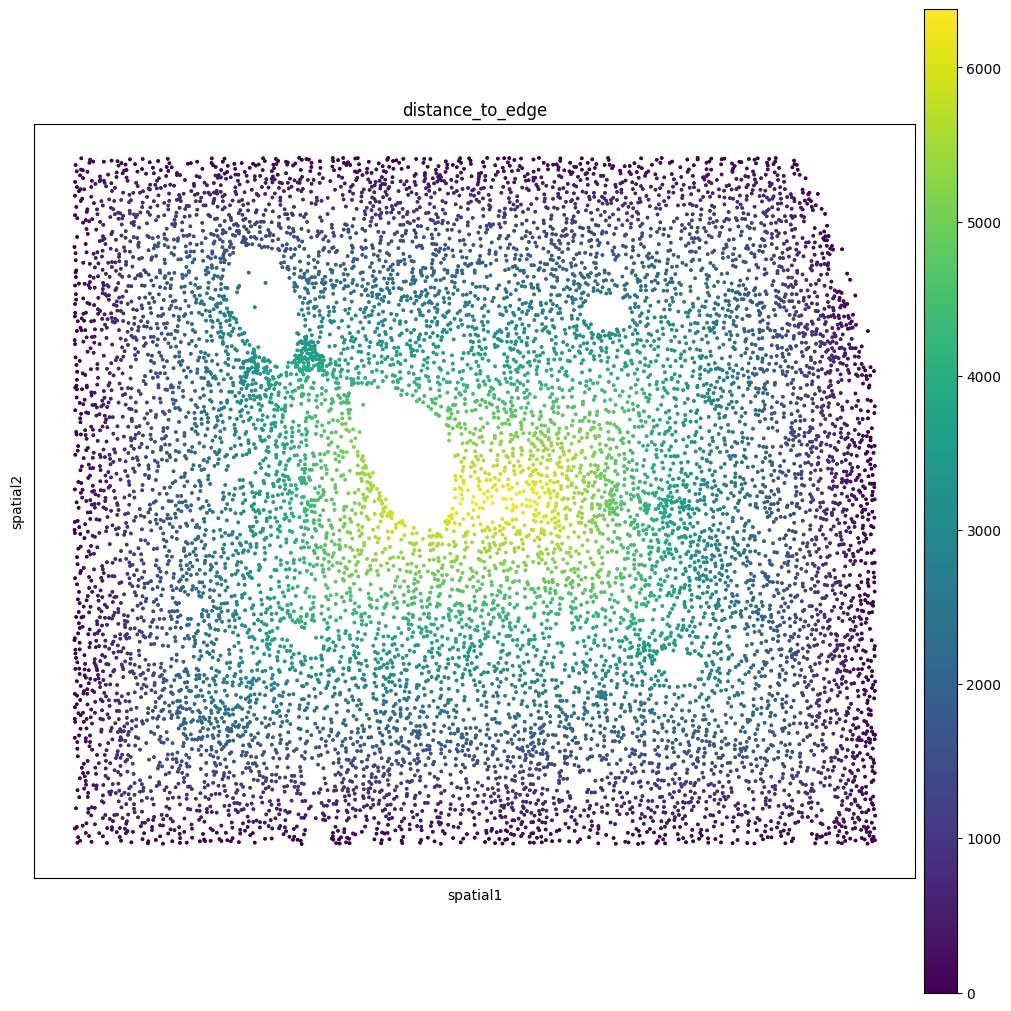

In [27]:
sq.pl.spatial_scatter(anndata,color='distance_to_edge',shape=None, figsize=(10, 10)) 

In [31]:
anndata.write(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances.h5ad')

In [32]:
anndata.obs

,region,instance,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_2_genes,pct_counts_in_top_5_genes,n_counts,shapeSize,...,annotation_own_score_genes_start_iterative_HLMartin_7,annotation_tangram_11,annotation_tangram_7,distance_to_edge,distance_to_vein,area,eccentricity,extent,solidity,intensity_mean
cells,,,,,,,,,,,,,,,,,,,,,
335,1,1,7,2.079442,25,3.258097,60.000000,92.000000,25,3368.0,...,Strom,Meso,Strom,5.000000,349.400916,3368.0,0.814145,0.690872,0.922993,3321.482185
359,1,1,5,1.791759,247,5.513429,90.688259,100.000000,247,3596.0,...,Unknown,Hepa,Hepa,107.000000,1254.971713,3596.0,0.450551,0.704269,0.948813,5141.758621
431,1,1,8,2.197225,56,4.043051,71.428571,92.857143,56,2868.0,...,Hepa,Hepa,Hepa,370.000000,538.282454,2868.0,0.411929,0.735385,0.977172,5656.474895
439,1,1,11,2.484907,216,5.379897,69.907407,93.055556,216,3595.0,...,Hepa,Hepa,Hepa,91.000000,2579.544533,3595.0,0.393648,0.639566,0.914526,5085.805563
471,1,1,5,1.791759,124,4.828314,91.935484,100.000000,124,3080.0,...,Unknown,Hepa,Hepa,161.607549,1320.898179,3080.0,0.874463,0.720131,0.962801,4359.947403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35146,1,1,16,2.833213,47,3.871201,38.297872,68.085106,47,2793.0,...,Endo,Hepa,Hepa,4016.119645,10.049876,2793.0,0.846799,0.654098,0.969792,7264.488006
35210,1,1,6,1.945910,43,3.784190,76.744186,97.674419,43,1357.0,...,Endo,Portal vein,Endo,4019.000000,0.000000,1357.0,0.340042,0.807738,0.976259,8306.563007
35274,1,1,4,1.609438,13,2.639057,76.923077,100.000000,13,1348.0,...,Strom,Hepa,Hepa,4026.152133,19.209373,1348.0,0.770103,0.655005,0.932872,3836.213650


: 